In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
# from tensorflow import keras
# from tensorflow.keras import layers
import numpy as np

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt

print(tf.__version__)

2.6.0


In [ ]:
# (mnist_train, mnist_test), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
dim = 28
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # return tf.cast(image, tf.float32) / 255., label
    return tf.cast(tf.reshape(image,[dim**2]), tf.float32) / 255., label
    # x = tf.cast(tf.reshape(image,[dim**2]), tf.float32) / 255.
    # return tf.concat([x, 1-x], 0), label


ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


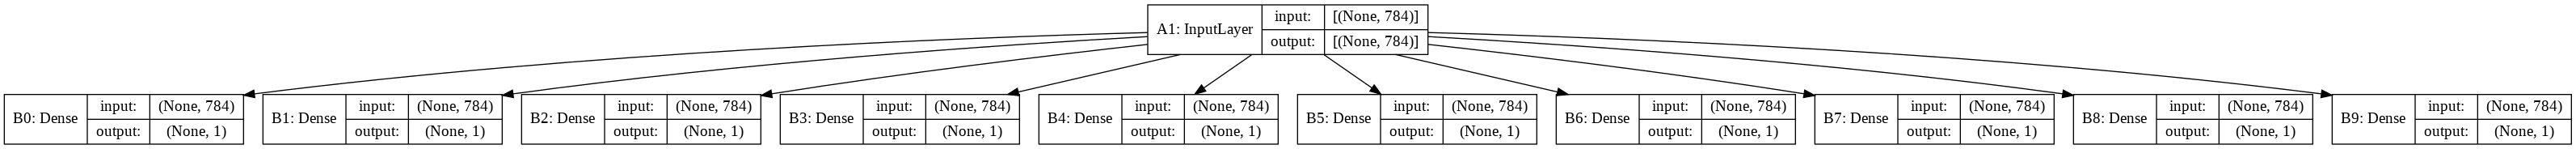

In [ ]:
dim = 28
n_categories = 10

# List of head node names
layer_names = ['B'+str(i) for i in range(n_categories)]

# Activate nodes function
def activate_nodes(model):
    # Make the head nodes trainable again
    for layer in model.layers:
        if layer.name in layer_names:
            layer.trainable = True

# Make only winner activated
def activate_one_node(model, index):
    winner_name = 'B'+str(int(index))
    for layer in model.layers:
        if (layer.name in layer_names) and (layer.name != winner_name):
            layer.trainable = False

# Normalize weights for visualization
def get_normalized_weights(weights):
    f_min, f_max = weights.min(), weights.max()
    new_weights = (weights - f_min) / (f_max - f_min)
    return new_weights

# Make the weights square for visualization
def get_square_weights(model, index):
    # Get the weights
    weights, biases = model.layers[index+1].get_weights()
    # Normalize
    weights = get_normalized_weights(weights)
    # Reshape and return
    return np.reshape(weights, (dim, dim))

# Visualize one weight from the model
def visualize_weights(model, index):
    # Get the square weights
    f = get_square_weights(model, index)
    # Plot in grayscale
    ax = plt.plot()
    plt.imshow(f, cmap='gray')

# Show all weights in a 3x3
def visualize_all_weights(model):
    plt.figure()
    n_ax, n_plot = 3, 9
    for ix in range(n_plot):
        plt.subplot(n_ax, n_ax, ix+1)
        f = get_square_weights(model, ix)
        plt.imshow(f, cmap='gray')

# Repor the trainable layers
def check_trainable(model):
    for layer in model.layers:
        print(layer.name + ": " + str(layer.trainable))
# Model 1: One-Layer
# A1 = Input(shape=(dim, dim, 1),name='A1')
# A2 = Flatten(name='Flatten')(A1)
# head_nodes = [Dense(1, activation='sigmoid',name='B'+str(i))(A2) for i in range(n_categories)]

# # Model 2: Two-Layer
# A1 = Input(shape=(dim, dim, 1),name='A1')
# A2 = Flatten(name='Flatten')(A1)
# A3 = Dense(128, activation='relu',name='A3')(A2)
# head_nodes = [Dense(1, activation='sigmoid',name='B'+str(i))(A3) for i in range(n_categories)]

# Model 3: One-Layer Pre-Flattened
# Complement-coded
# A1 = Input(shape=(2*dim**2), name='A1')
# Un-complement-coded
A1 = Input(shape=(dim**2), name='A1')
head_nodes = [Dense(1, activation='sigmoid', name='B'+str(i))(A1) for i in range(n_categories)]

merged = Model(inputs=[A1],outputs=head_nodes)
plot_model(merged,to_file='demo.png',show_shapes=True)

# new_node = Dense(1, activation='sigmoid', name='B20')(A1)
# head_nodes.append(new_node)
# merged2 = Model(inputs=[A1], outputs=head_nodes)
# plot_model(merged2,to_file='demo2.png',show_shapes=True)

In [ ]:
# merged.compile(optimizer="Adam", loss="mse", metrics=["mae"])
merged.compile(optimizer="Adam", metrics=["mae"])
merged.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
A1 (InputLayer)                 [(None, 784)]        0                                            
__________________________________________________________________________________________________
B0 (Dense)                      (None, 1)            785         A1[0][0]                         
__________________________________________________________________________________________________
B1 (Dense)                      (None, 1)            785         A1[0][0]                         
__________________________________________________________________________________________________
B2 (Dense)                      (None, 1)            785         A1[0][0]                         
______________________________________________________________________________________________

## Test an input into the model

In [ ]:
# Complement-coded
# sample = tf.ones((1, 2*dim**2))
# Un-complement-coded
sample = tf.ones((1, dim**2))
# sample = tf.ones((1,dim,dim,1))
y = merged(sample)
print("y is:" + str(y))
print("max y is:" + str(max(y)))

# Winning index
index = tf.math.argmax(y)[0][0]
print("Index is: " + str(index))
print(y[index])

# Winning node name
layer_name = 'B'+str(int(index))
print("winning node is: " + layer_name)
# Set winner to trainable
activate_one_node(merged, index)
check_trainable(merged)

print("Loss is:" + str(1-y[index]))

y is:
[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.05012366]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.18307573]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.54736364]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9235041]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.92712]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.186658]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.26946223]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.19784749]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.73219967]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.29081866]], dtype=float32)>]
max y is:
tf.Tensor([[0.92712]], shape=(1, 1), dtype=float32)
Index is: tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor([[0.92712]], shape=(1

## Test the GradientTape

Winning index: 4
Loss: tf.Tensor(0.07288003, shape=(), dtype=float32)
Trainable variables: 2
Trainable weights: 2
Non-trainable weights: 18
Number of grads: 2
Number of grads in top: 784


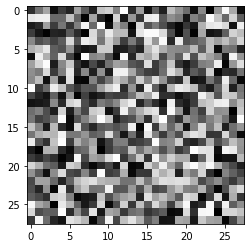

In [ ]:
# List of head node names
layer_names = ['B'+str(i) for i in range(n_categories)]

# Make the head nodes trainable again
activate_nodes(merged)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(sample)
    pred = merged(sample)
    # Get the index of the winning node
    index = tf.math.argmax(pred)[0][0]
    activate_one_node(merged, int(index))
    total_loss = 1 - pred[index][0][0]
    # expected_loss = 1 - pred[index][0][0] + pred[index][0][0] - 0.001
    # expected_loss = tf.Variable(0.0)
    # tape.watch(expected_loss)
grads = tape.gradient(total_loss, merged.trainable_variables)
print("Winning index: " + str(int(index)))
print("Loss: " + str(total_loss))
print("Trainable variables: " + str(len(merged.trainable_variables)))
print("Trainable weights: " + str(len(merged.trainable_weights)))
print("Non-trainable weights: " + str(len(merged.non_trainable_weights)))
print("Number of grads: " + str(len(grads)))
print("Number of grads in top: " + str(len(grads[0])))

# Get the gradient wrt the sample
expected_grads = tape.gradient(total_loss, sample)
expected_grads = expected_grads.numpy()
f_min, f_max = expected_grads.min(), expected_grads.max()
expected_grads = (expected_grads - f_min) / (f_max - f_min)
square_grads = np.reshape(expected_grads, (dim, dim))
plt.figure()
plt.imshow(square_grads, cmap='gray')

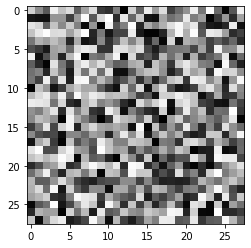

In [ ]:
visualize_weights(merged, 4)

## Check the difference between the input grads and weights

1.0000001
0.51722866
1.0


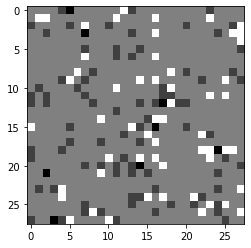

In [ ]:
# Get and normalize the weights
weights, biases = merged.layers[index+1].get_weights()
weights = get_normalized_weights(weights)
square_weights = np.reshape(weights, (dim, dim))
# diff = square_weights - (1- square_grads)
diff = square_weights + square_grads
print(np.max(diff))
print(np.average(weights))
print(np.average(diff))
plt.figure()
plt.imshow(diff, cmap='gray')

## Make a deeper network

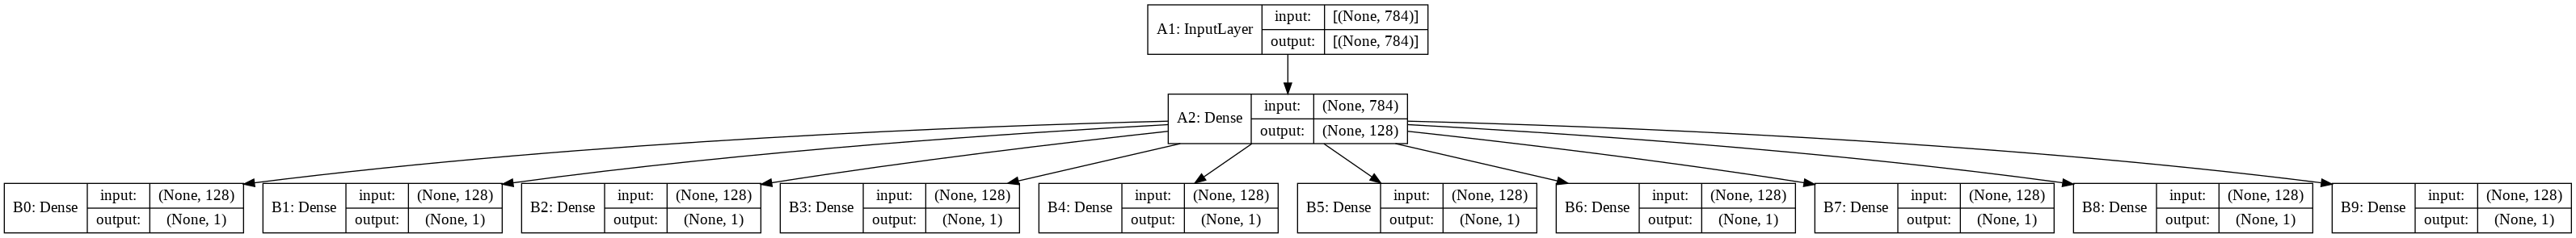

In [ ]:
# Model 2: Two-Layer
A1 = Input(shape=(dim**2),name='A1')
A2 = Dense(128, activation='relu',name='A2')(A1)
head_nodes = [Dense(1, activation='sigmoid',name='B'+str(i))(A2) for i in range(n_categories)]

merged_deep = Model(inputs=[A1],outputs=head_nodes)

# merged.compile(optimizer="Adam", loss="mse", metrics=["mae"])
merged_deep.compile(optimizer="Adam", metrics=["mae"])
# merged_deep.summary()
plot_model(merged_deep,to_file='demo.png',show_shapes=True)

## ???

In [ ]:
def train_art_deep(model, train, test, epochs=6):
    # List of head node names
    layer_names = ['B'+str(i) for i in range(n_categories)]

    # Make the head nodes trainable again
    for layer in model.layers:
        if layer.name in layer_names:
            layer.trainable = True

    # Iterate over all batches
    for batch, (imgs, labels) in enumerate(train):
        # Iterate over every image and label
        for img, label in zip(imgs, labels):
            # print("label is: " + str(label))
            # Expand the image dim becuase we are using one image at a time
            # x = np.expand_dims(img, axis=0)
            x = tf.expand_dims(img, axis=0)
            # print(type(img))
            # Begin computing gradients
            with tf.GradientTape(persistent=True) as tape:
                tape.watch(x)
                # Get the predictions
                pred = model(x)
                # Get the index of the winning node
                winner = tf.math.argmax(pred)[0][0]
                # Turn off learning in the top nodes aside from the label
                index = label
                activate_one_node(model, index)
                # for layer in model_bu.layers:
                #     if (layer.name in layer_names) and (layer.name != winner_name):
                #         layer.trainable = False
                total_loss = 1 - pred[index][0][0]
                # print("loss: " + str(total_loss))

            # grads = tape.gradient(total_loss, model.trainable_variables)
            grads = tape.gradient(total_loss, model.trainable_variables)
            sample_grads = tape.gradient(total_loss, x)
            sample_grad_avg = tf.math.reduce_mean(sample_grads)
            # print(sample_grad_avg)

            accuracy.update_state(label, winner)

            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Make the head nodes trainable again
            activate_nodes(model)
            for layer in model.layers:
                if layer.name in layer_names:
                    layer.trainable = True

                # total_loss = model.loss(labels, preds) + l2_penalty(model.trainable_variables, theta_A)
                # total_loss = model_bu.loss(labels, pred)
                # preds = model(imgs)
#     #         total_loss = model.loss(labels, preds) + l2_penalty(model.trainable_variables, theta_A)
        # grads = tape.gradient(total_loss, model.trainable_variables)
        # model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

#     #     accuracy.update_state(labels, preds)
#     #     loss.update_state(labels, preds)
        # print("\rEpoch: {}, Batch: {}, Loss: {:.3f}, Accuracy: {:.3f}".format(
        #     epoch+1, batch+1, loss.result().numpy(), accuracy.result().numpy()), flush=True, end=''
        #     )
#     #     print("")

train_art_deep(merged_deep, ds_train, ds_test, epochs=1)
# train_art(merged, ds_train, ds_test, epochs=1)
# train_art(head_nodes, ds_train, ds_test, epochs=1)


tf.Tensor(0.00016383699, shape=(), dtype=float32)
tf.Tensor(-0.00034506968, shape=(), dtype=float32)
tf.Tensor(0.00032449226, shape=(), dtype=float32)
tf.Tensor(0.00038880878, shape=(), dtype=float32)
tf.Tensor(-6.709422e-05, shape=(), dtype=float32)
tf.Tensor(-0.00035863504, shape=(), dtype=float32)
tf.Tensor(0.00017627869, shape=(), dtype=float32)
tf.Tensor(0.00048698936, shape=(), dtype=float32)
tf.Tensor(-6.961478e-05, shape=(), dtype=float32)
tf.Tensor(0.00013492389, shape=(), dtype=float32)
tf.Tensor(-0.0003400266, shape=(), dtype=float32)
tf.Tensor(-0.00020967238, shape=(), dtype=float32)
tf.Tensor(-0.00035983766, shape=(), dtype=float32)
tf.Tensor(-0.00047601433, shape=(), dtype=float32)
tf.Tensor(0.000312829, shape=(), dtype=float32)
tf.Tensor(-0.0007359159, shape=(), dtype=float32)
tf.Tensor(-0.0012349961, shape=(), dtype=float32)
tf.Tensor(-0.00060768507, shape=(), dtype=float32)
tf.Tensor(-0.0006895148, shape=(), dtype=float32)
tf.Tensor(-0.00062079274, shape=(), dtype=floa

KeyboardInterrupt: ignored

In [ ]:
visualize_weights(merged_deep, 1)

ValueError: ignored

# Supervised Example

In [ ]:
def train_art(model_bu, train, test, epochs=6):
    # List of head node names
    layer_names = ['B'+str(i) for i in range(n_categories)]

    # Make the head nodes trainable again
    for layer in model_bu.layers:
        if layer.name in layer_names:
            layer.trainable = True

    # Iterate over all batches
    for batch, (imgs, labels) in enumerate(train):
        # Iterate over every image and label
        for img, label in zip(imgs, labels):
            # print("label is: " + str(label))
            # Expand the image dim becuase we are using one image at a time
            x = np.expand_dims(img, axis=0)
            # Begin computing gradients
            with tf.GradientTape(persistent=True) as tape:
                # Get the predictions
                pred = model_bu(x)
                # Get the index of the winning node
                index = tf.math.argmax(pred)[0][0]
                # Get the name of the winning node
                # winner_name = 'B'+str(int(index))
                # print("winning node is: " + winner_name)
                # Turn off learning in the top nodes aside from the label
                index = label
                # winner_name = 'B'+str(int(index))
                # print("label node is: " + winner_name)
                activate_one_node(model_bu, index)
                # for layer in model_bu.layers:
                #     if (layer.name in layer_names) and (layer.name != winner_name):
                #         layer.trainable = False
                total_loss = 1 - pred[index][0][0]
                # print("loss: " + str(total_loss))

            # grads = tape.gradient(total_loss, model_bu.trainable_variables)
            grads = tape.gradient(total_loss, model_bu.trainable_variables)
            expected_grads = tape.gradient(0, model_bu.trainable_variables)

            model_bu.optimizer.apply_gradients(zip(grads, model_bu.trainable_variables))

            # Make the head nodes trainable again
            activate_nodes(model_bu)
            for layer in model_bu.layers:
                if layer.name in layer_names:
                    layer.trainable = True

                # total_loss = model.loss(labels, preds) + l2_penalty(model.trainable_variables, theta_A)
                # total_loss = model_bu.loss(labels, pred)
                # preds = model(imgs)
#     #         total_loss = model.loss(labels, preds) + l2_penalty(model.trainable_variables, theta_A)
        # grads = tape.gradient(total_loss, model.trainable_variables)
        # model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

#     #     accuracy.update_state(labels, preds)
#     #     loss.update_state(labels, preds)
        # print("\rEpoch: {}, Batch: {}, Loss: {:.3f}, Accuracy: {:.3f}".format(
        #     epoch+1, batch+1, loss.result().numpy(), accuracy.result().numpy()), flush=True, end=''
        #     )
#     #     print("")

train_art(merged, ds_train, ds_test, epochs=1)
# train_art(merged, ds_train, ds_test, epochs=1)
# train_art(head_nodes, ds_train, ds_test, epochs=1)


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f6bd0b70b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

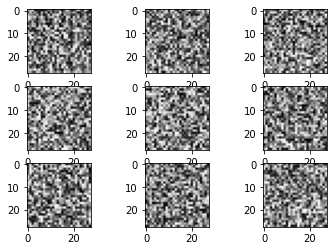

In [ ]:
visualize_all_weights(merged)

0.20620377


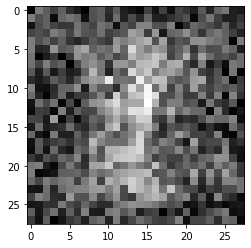

In [ ]:
visualize_weights(merged, 1)
print(np.max(merged.layers[1].get_weights()[0]))

# Unsupervised example

In [ ]:
def l2_penalty(theta, theta_A):
    penalty = 0
    for i, theta_i in enumerate(theta):
        penalty += tf.math.reduce_sum(tf.math.square(theta_i - theta_A[i]))
    return 0.5*penalty

def train_art(model_bu, train, test, epochs=6):
    # We'll only compute Fisher once, you can do it whenever
    # F = compute_precision_matrices(model, task_A_set, num_batches=1000)
    theta_bu = {n: p.value() for n, p in enumerate(model_bu.trainable_variables.copy())}

    # accuracy_bu = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    # loss_bu = tf.keras.metrics.SparseCategoricalCrossentropy('loss')

    # List of head node names
    layer_names = ['B'+str(i) for i in range(n_categories)]

    # Make the head nodes trainable again
    for layer in model_bu.layers:
        if layer.name in layer_names:
            layer.trainable = True

    # Iterate over all batches
    for batch, (imgs, labels) in enumerate(train):
        # Iterate over every image and label
        for img, label in zip(imgs, labels):
            # print("label is: " + str(label))
            # Expand the image dim becuase we are using one image at a time
            x = np.expand_dims(img, axis=0)
            # Get the predictions
            pred = model_bu(x)
            print(pred)
            # Get the index of the winning node
            index = tf.math.argmax(pred)[0][0]
            # Get the name of the winning node
            winner_name = 'B'+str(int(index))
            print("winning node is: " + layer_name)
            # Turn off learning in the top nodes aside from the
            for layer in model_bu.layers:
                if (layer.name in layer_names) and (layer.name != winner_name):
                    layer.trainable = False

            # Begin computing gradients
            with tf.GradientTape() as tape:
                # Recompute the prediction
                pred = model_bu(x)
                total_loss = 1 - pred[index][0][0]
                print("loss: " + str(total_loss))
            grads = tape.gradient(total_loss, model_bu.trainable_variables)
            model_bu.optimizer.apply_gradients(zip(grads, model_bu.trainable_variables))

            # Make the head nodes trainable again
            for layer in model_bu.layers:
                if layer.name in layer_names:
                    layer.trainable = True

            #     print(pred)

                # total_loss = model.loss(labels, preds) + l2_penalty(model.trainable_variables, theta_A)
                # total_loss = model_bu.loss(labels, pred)
                # preds = model(imgs)
#     #         total_loss = model.loss(labels, preds) + l2_penalty(model.trainable_variables, theta_A)
        # grads = tape.gradient(total_loss, model.trainable_variables)
        # model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

#     #     accuracy.update_state(labels, preds)
#     #     loss.update_state(labels, preds)
#     #     print("\rEpoch: {}, Batch: {}, Loss: {:.3f}, Accuracy: {:.3f}".format(
#     #         epoch+1, batch+1, loss.result().numpy(), accuracy.result().numpy()), flush=True, end=''
#     #         )
#     #     print("")

train_art(merged, ds_train, ds_test, epochs=1)
# train_art(merged, ds_train, ds_test, epochs=1)
# train_art(head_nodes, ds_train, ds_test, epochs=1)


In [ ]:
ds_train

<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

# Backup

In [ ]:
def l2_penalty(theta, theta_A):
    penalty = 0
    for i, theta_i in enumerate(theta):
        penalty += tf.math.reduce_sum(tf.math.square(theta_i - theta_A[i]))
    return 0.5*penalty

def train_art(model_bu, train, test, epochs=6):
    # We'll only compute Fisher once, you can do it whenever
    # F = compute_precision_matrices(model, task_A_set, num_batches=1000)
    theta_bu = {n: p.value() for n, p in enumerate(model_bu.trainable_variables.copy())}

    # accuracy_bu = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    # loss_bu = tf.keras.metrics.SparseCategoricalCrossentropy('loss')

    # List of head node names
    layer_names = ['B'+str(i) for i in range(n_categories)]

    # Make the head nodes trainable again
    for layer in model_bu.layers:
        if layer.name in layer_names:
            layer.trainable = True

    # Iterate over all batches
    for batch, (imgs, labels) in enumerate(train):
        # Iterate over every image and label
        for img, label in zip(imgs, labels):
            # print("label is: " + str(label))
            # Expand the image dim becuase we are using one image at a time
            x = np.expand_dims(img, axis=0)
            # Get the predictions
            pred = model_bu(x)
            print(pred)
            # Get the index of the winning node
            index = tf.math.argmax(pred)[0][0]
            # Get the name of the winning node
            winner_name = 'B'+str(int(index))
            print("winning node is: " + layer_name)
            # Turn off learning in the top nodes aside from the
            for layer in model_bu.layers:
                if (layer.name in layer_names) and (layer.name != winner_name):
                    layer.trainable = False

            # Begin computing gradients
            with tf.GradientTape() as tape:
                # Recompute the prediction
                pred = model_bu(x)
                total_loss = 1 - pred[index][0][0]
                print("loss: " + str(total_loss))
            grads = tape.gradient(total_loss, model_bu.trainable_variables)
            model_bu.optimizer.apply_gradients(zip(grads, model_bu.trainable_variables))

            # Make the head nodes trainable again
            for layer in model_bu.layers:
                if layer.name in layer_names:
                    layer.trainable = True

            #     print(pred)

                # total_loss = model.loss(labels, preds) + l2_penalty(model.trainable_variables, theta_A)
                # total_loss = model_bu.loss(labels, pred)
                # preds = model(imgs)
#     #         total_loss = model.loss(labels, preds) + l2_penalty(model.trainable_variables, theta_A)
        # grads = tape.gradient(total_loss, model.trainable_variables)
        # model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

#     #     accuracy.update_state(labels, preds)
#     #     loss.update_state(labels, preds)
#     #     print("\rEpoch: {}, Batch: {}, Loss: {:.3f}, Accuracy: {:.3f}".format(
#     #         epoch+1, batch+1, loss.result().numpy(), accuracy.result().numpy()), flush=True, end=''
#     #         )
#     #     print("")

train_art(merged, ds_train, ds_test, epochs=1)
# train_art(merged, ds_train, ds_test, epochs=1)
# train_art(head_nodes, ds_train, ds_test, epochs=1)


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255
sample = x_train[0]
merged(sample)

In [ ]:
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))

In [ ]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu")(inputs)
x2 = layers.Dense(64, activation="relu")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the training dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

11501568/11490434 [==============================] - 0s 0us/step
